In [ ]:
from google.colab import drive
import os
import pandas as pd


drive.mount('/content/drive')
# Replace with your own path

mnist_data = pd.read_csv('/content/drive/MyDrive/mnist.csv').values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
digits_square = digits.reshape(digits.shape[0],img_size, img_size)

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import psutil

# Resize images to (42000,14,14)
(N, H, W) = digits_square.shape

new_H = int(H)
new_W = int(W)
digits_square_resized_flattened = np.empty((N, new_H * new_W))

# Change the 'dtype' of digits_square because it is required by cv2
digits_square = np.array(digits_square, dtype='uint8')

for i in range(N):
    digits_square_resized_flattened[i] = cv2.resize(digits_square[i], (new_H, new_W)).flatten()

labels_reshaped = labels.reshape(-1, 1)

# Split dataset and fmatten images
X_train, X_test, y_train, y_test = train_test_split(digits_square_resized_flattened, labels_reshaped, test_size=37000, random_state=42)

X_train_flattened_scaled = scale(X_train)
X_test_flattened_scaled = scale(X_test)


# ------------------------------RandomSearch----------------------------

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Perform standard scaling
    ('svm', SVC())                 # Apply SVM
])

param_dist = {
    'svm__C': uniform(loc=0.001, scale=100),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}



random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)


X_train, X_test, y_train, y_test = train_test_split(digits_square_resized_flattened, labels_reshaped, test_size=37000, random_state=42)

random_search.fit(X_train_flattened_scaled, y_train.ravel())

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'svm__C': 70.80825777960456, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}


In [ ]:
# Extract best parameters and remove the 'svm__' prefix
best_params_stripped = {key.replace('svm__', ''): value for key, value in random_search.best_params_.items()}
print(best_params_stripped)
# Create a new pipeline with the best parameters

start_time = time.time()

best_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**best_params_stripped))
])

# Fit the pipeline on the training data
best_svm_pipeline.fit(X_train, y_train.ravel())

svm_training_time = time.time() - start_time

print(f"SVM Training Time: {svm_training_time} seconds")


# Obtain predictions using the pipeline to ensure consistent scaling
predicted_labels_svm_grid = best_svm_pipeline.predict(X_test)


{'C': 70.80825777960456, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
SVM Training Time: 6.819295167922974 seconds


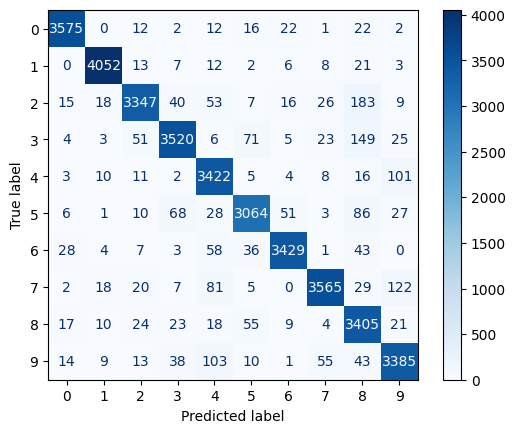

Accuracy with Random search for Best Hyper-parameters: 0.9395675675675675


In [ ]:
# ------------------------------RandomSearch----------------------------
# Comfusion Matrix
cm_svm_grid = confusion_matrix(y_test, predicted_labels_svm_grid)
disp_svm_grid = ConfusionMatrixDisplay(confusion_matrix=cm_svm_grid, display_labels=best_svm_pipeline.classes_)
disp_svm_grid.plot(cmap='Blues')
plt.show()

# SVM Accuracy
accuracy_svm_grid = accuracy_score(y_test, predicted_labels_svm_grid)
print("Accuracy with Random search for Best Hyper-parameters:", accuracy_svm_grid)


In [ ]:
#------------------------------------------------- Multinomial Logistic Regression --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression


start_time = time.time()

mult_logit_model = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', max_iter=1000)
mult_logit_model.fit(X_train_flattened_scaled, y_train.ravel())

svm_training_time = time.time() - start_time

print(f"Logit Training Time: {svm_training_time} seconds")


# Predict and evaluate
predicted_labels_mult_logit_model = mult_logit_model.predict(X_test_flattened_scaled)


Logit Training Time: 753.311755657196 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


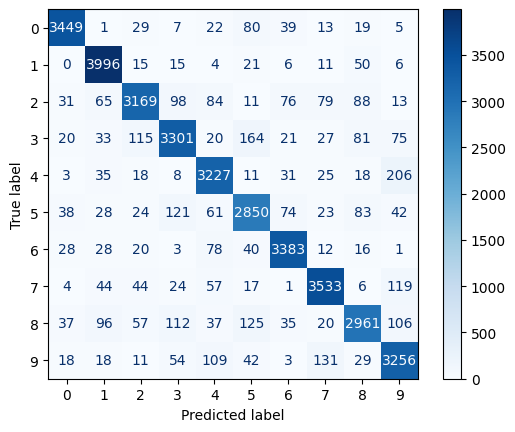

In [ ]:
# Confusion Matrix
cm_mult_logit_model = confusion_matrix(y_test, predicted_labels_mult_logit_model)
disp_mult_logit_model = ConfusionMatrixDisplay(confusion_matrix=cm_mult_logit_model, display_labels=mult_logit_model.classes_)
disp_mult_logit_model.plot(cmap='Blues')
plt.show()

In [ ]:
# Multinomial logit Accuracy
accuracy_logit = accuracy_score(y_test, predicted_labels_mult_logit_model)
print("Accuracy For Multinomial Logistic Regression:", accuracy_logit)

Accuracy For Multinomial Logistic Regression: 0.8952702702702703


In [ ]:
print(f"Logit Training Time: {svm_training_time} seconds")


# Predict and evaluate
predicted_labels_mult_logit_model = mult_logit_model.predict(X_test_flattened_scaled)

Logit Training Time: 753.311755657196 seconds


In [ ]:
from PIL import Image
import numpy as np

# Load image (make sure to replace 'path_to_image' with your actual image path)
image = Image.open('/content/drive/MyDrive/christos_digits/6_6.jpg').convert('L')  # Convert to grayscale

# Resize image to 14x14 pixels
image_resized = image.resize((28, 28))

# Convert image to numpy array
image_array = np.array(image_resized)

# Normalize the image array if needed (MNIST images are typically in range [0, 1] or [0, 255])
image_array_normalized = image_array / 255.0

# Flatten the array if your model expects flattened input
image_array_flattened = image_array_normalized.flatten().reshape(1, -1)

# Predict with your model (replace 'your_model' with your actual model)
prediction = mult_logit_model.predict(image_array_flattened)

print(f'The model predicts this digit is a: {prediction[0]}')


FileNotFoundError: ignored

In [ ]:
from PIL import Image
import numpy as np

# Load image (make sure to replace 'path_to_image' with your actual image path)
image = Image.open('/content/drive/MyDrive/christos_digits/5.jpg').convert('L')  # Convert to grayscale




# Resize image to 14x14 pixels
image_resized = image.resize((28, 28))

# Convert image to numpy array
image_array = np.array(image_resized)

# Normalize the image array if needed (MNIST images are typically in range [0, 1] or [0, 255])
image_array_normalized = image_array / 255.0

#print(image_array_normalized)

# Flatten the array if your model expects flattened input
image_array_flattened = image_array_normalized.flatten().reshape(1, -1)
plt.imshow(image_array_normalized, cmap='gray')
plt.show()

# Predict with your model (replace 'your_model' with your actual model)
prediction = best_svm_pipeline.predict(image_array_flattened)

print(f'The model predicts this digit is a: {prediction[0]}')

NameError: ignored

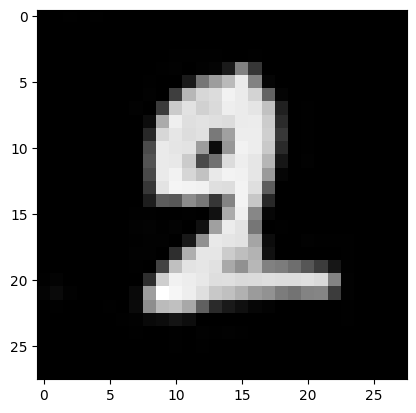

In [ ]:
plt.imshow(image_array_normalized, cmap='gray')
plt.show()

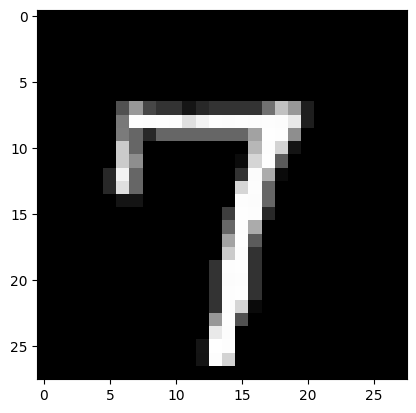

In [ ]:
plt.imshow(digits[6].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
digits[0].shape

(784,)

In [ ]:
#-------------------------- Remove useless digits -----------------------#

useless_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 52, 53, 54, 55, 56, 57, 82, 83, 84,
                  85, 111, 112, 139, 140, 141, 168, 196, 392, 420, 421, 448, 476, 532, 560, 644, 645, 671, 672, 673, 699, 700, 701, 727, 728, 729, 730, 731,
                  754, 755, 756, 757, 758, 759, 760, 780, 781, 782, 783]


digits_np = np.array(digits)

new_digits = []


for i in range(len(digits)):
  new_digits.append(np.delete(digits_np[i], useless_digits))

new_digits_np = np.array(new_digits)


In [ ]:
predicted_labels_svm_grid = best_svm_pipeline.predict(digits)



In [ ]:
from sklearn.metrics import f1_score

# Assuming y_test contains the true labels, and y_pred contains the predictions from your model
y_pred = mult_logit_model.predict(X_test)

# Calculate the F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Macro F1 Score: {f1_macro}')
print(f'Weighted F1 Score: {f1_weighted}')


Macro F1 Score: 0.7851704348251342
Weighted F1 Score: 0.7906087851377434


In [ ]:
from sklearn.metrics import f1_score

# Assuming y_test contains the true labels, and y_pred contains the predictions from your model
y_pred = best_svm_pipeline.predict(X_test)

# Calculate the F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Macro F1 Score: {f1_macro}')
print(f'Weighted F1 Score: {f1_weighted}')


Macro F1 Score: 0.9391045728576204
Weighted F1 Score: 0.9397996724388813
